In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,39133,None,None,85806.788161
2020-06-13,39134,None,None,79719.156807
2020-06-14,39135,None,None,74064.535354
2020-06-15,39136,None,None,68738.526181
2020-06-16,39137,None,None,63994.632061
...,...,...,...,...
2021-03-13,39407,None,None,96971.186606
2021-03-14,39408,None,None,92907.641676
2021-03-15,39409,None,None,89427.187341


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-17_2021-03-17-16-17.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-16_2021-03-16-16-42.pickle


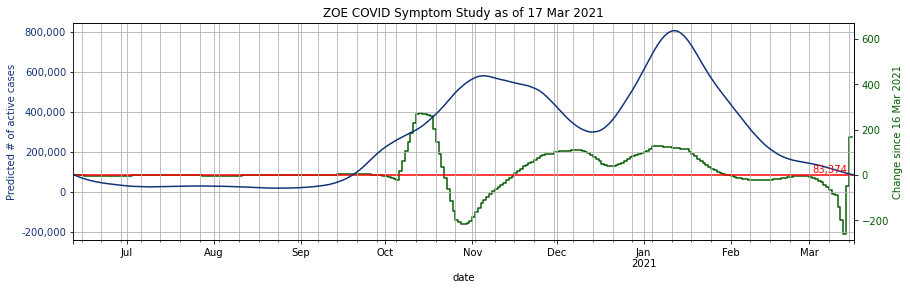

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

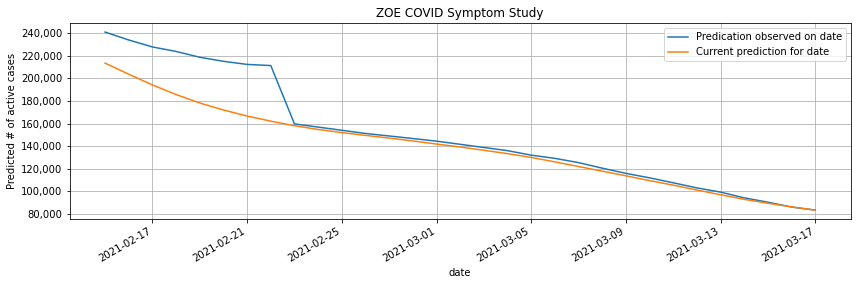

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-03-17_2021-03-17-16-17.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
373,North Ayrshire,S12000021,1.173243
272,Tameside,E08000008,0.790687
280,Doncaster,E08000017,0.614531
295,East Renfrewshire,S12000011,0.572242
46,Northumberland,E06000057,0.565552
308,Perth and Kinross,S12000024,0.555952
323,North Lanarkshire,S12000044,0.525281
115,Eastbourne,E07000061,0.493886
112,East Dorset,E07000049,0.484600
277,St. Helens,E08000013,0.472127
